In [89]:
import datetime as dt
import os
import matplotlib.pyplot as plt
import pytz

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.auth.exceptions import RefreshError

from authenticate import authenticate_google_calendar


# API Utilities

In [90]:
def get_local_timezone():
    """Return the local timezone based on the current UTC time."""
    return dt.datetime.now(dt.timezone.utc).astimezone().tzinfo

def authenticate_google_calendar_with_retry():
    """
    Authenticate with Google Calendar. If the token is expired or revoked,
    delete the token file and retry.
    """
    try:
        # This function should return either a service resource or credentials.
        # Depending on your implementation of authenticate_google_calendar(),
        # adjust the code accordingly.
        creds_or_service = authenticate_google_calendar()
        return creds_or_service
    except RefreshError as e:
        if "invalid_grant" in str(e):
            print("Error: Token has been expired or revoked. Deleting token.json and retrying...")
            if os.path.exists("token.json"):
                os.remove("token.json")
            creds_or_service = authenticate_google_calendar()
            return creds_or_service
        else:
            raise

def fetch_calendar_names(creds_or_service):
    """
    Fetch calendar names for the authenticated user.
    
    If the passed object already is a built service (i.e. has a 'calendarList' attribute),
    it uses it directly; otherwise, it builds the service using the credentials.
    
    Returns:
        dict: A dictionary mapping calendar IDs to calendar names.
    """
    # If the object has the 'calendarList' attribute, assume it's already a service.
    if hasattr(creds_or_service, "calendarList"):
        service = creds_or_service
    else:
        service = build("calendar", "v3", credentials=creds_or_service)
    
    calendar_list = service.calendarList().list().execute()
    calendar_name_map = {}
    for calendar in calendar_list.get("items", []):
        calendar_id = calendar.get("id")
        summary = calendar.get("summary", "No Name")
        calendar_name_map[calendar_id] = summary
    return calendar_name_map

# Get the service or credentials using the retry function
creds_or_service = authenticate_google_calendar_with_retry()
# Build the calendar name map
calendar_name_map = fetch_calendar_names(creds_or_service)
print("Calendar name map:", calendar_name_map)


Calendar name map: {'b7ca60b7b46309b1e408a4a240a5456ca98cb4af51ad62d260ae8ae4fd0ce45d@group.calendar.google.com': 'Timetable', 'en.christian#holiday@group.v.calendar.google.com': 'Christian Holidays', 'o3ddi6qpfar9g43eldqb6ad2l6lipdml@import.calendar.google.com': 'Calendar', 'en.islamic#holiday@group.v.calendar.google.com': 'Muslim Holidays', 'en.judaism#holiday@group.v.calendar.google.com': 'Jewish Holidays', 'en.uk#holiday@group.v.calendar.google.com': 'Holidays in United Kingdom', 'g3uv76g8h69qah3p4i80bv5233up9nd9@import.calendar.google.com': 'https://files-f1.motorsportcalendars.com/f1-calendar_p1_p2_p3_qualifying_sprint_gp.ics?t=1677426916665', '6e609d607f04ff756b9050d7b8444d658f6b7c8914ded6b1066a33491b5b67e0@group.calendar.google.com': 'Time', '0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com': 'Studying', '90c68802d80f0e9b3643757199cad05eeaa8c1d02f655a7c7c5cc2c7de4d41f6@group.calendar.google.com': 'RescueTime', 'billjrimell@gmail.com': '

# Event Fetching Functions

In [91]:
def fetch_study_events(service, calendar_id, num_previous_days=30):
    """Fetch study events from a given calendar within the past 'num_previous_days'."""
    now = dt.datetime.utcnow().isoformat() + "Z"  # 'Z' indicates UTC
    start_date = dt.datetime.utcnow() - dt.timedelta(days=num_previous_days)
    start_date_iso = start_date.isoformat() + "Z"

    events_result = service.events().list(
        calendarId=calendar_id,
        timeMin=start_date_iso,
        timeMax=now,
        maxResults=10000,
        singleEvents=True,
        orderBy="startTime",
    ).execute()
    events = events_result.get("items", [])
    print(f"Found {len(events)} events in the past {num_previous_days} days from {calendar_name_map[calendar_id]}.")
    return events


# Daily Study Time Calculations

In [92]:
def calculate_planned_study_time_today(service, calendar_id, subjects):
    """
    Calculate the total planned study time for today (filtered by subject keywords).
    Merges overlapping events.
    """
    local_tz = get_local_timezone()
    today_start = dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_tz).isoformat()
    today_end = dt.datetime.now().replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_tz).isoformat()
    
    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=today_start,
            timeMax=today_end,
            singleEvents=True,
            orderBy='startTime'
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0

    events = events_result.get('items', [])
    if not events:
        print("No events found for today.")
        return 0

    intervals = []
    for event in events:
        if 'date' in event['start']:
            continue
        
        summary = event.get("summary", "").lower()
        if not any(term.lower() in summary for terms in subjects.values() for term in terms):
            continue

        start_str = event['start'].get('dateTime', event['start'].get('date'))
        end_str = event['end'].get('dateTime', event['end'].get('date'))
        start_time = dt.datetime.fromisoformat(start_str).astimezone(local_tz)
        end_time = dt.datetime.fromisoformat(end_str).astimezone(local_tz)
        new_interval = (start_time, end_time)
        merged = False
        for i, (s, e) in enumerate(intervals):
            if max(s, new_interval[0]) < min(e, new_interval[1]):
                intervals[i] = (min(s, new_interval[0]), max(e, new_interval[1]))
                merged = True
                break
        if not merged:
            intervals.append(new_interval)

    total_hours = sum((e - s).total_seconds() for s, e in intervals) / 3600
    print(f"Total planned study time for today (filtered by subjects): {total_hours:.1f} hours")
    return total_hours


def calculate_completed_study_time_today(service, calendar_id, subjects):
    """
    Calculate the total completed study time for today (filtered by subject keywords).
    For ongoing events, count only the elapsed time.
    """
    local_tz = get_local_timezone()
    today_start = dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_tz).isoformat()
    now = dt.datetime.now(tz=local_tz)
    
    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=today_start,
            timeMax=now.isoformat(),
            singleEvents=True,
            orderBy='startTime',
            maxResults=10000,
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0

    events = events_result.get('items', [])
    if not events:
        print("No events found for today.")
        return 0

    total_hours = 0
    for event in events:
        if 'date' in event['start']:
            continue
        summary = event.get("summary", "").lower()
        if not any(term.lower() in summary for terms in subjects.values() for term in terms):
            continue

        start_str = event['start'].get('dateTime')
        end_str = event['end'].get('dateTime')
        try:
            start_time = dt.datetime.fromisoformat(start_str)
            end_time = dt.datetime.fromisoformat(end_str)
        except Exception:
            continue
        if start_time.tzinfo is None:
            start_time = start_time.replace(tzinfo=local_tz)
        if end_time.tzinfo is None:
            end_time = end_time.replace(tzinfo=local_tz)

        if start_time > now:
            continue

        duration = (now - start_time) if now < end_time else (end_time - start_time)
        total_hours += duration.total_seconds() / 3600

    return total_hours


def calculate_daily_total_study_time(service, calendar_id, date):
    """
    Calculate total study time (without subject filtering) for a given day.
    """
    local_tz = get_local_timezone()
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_tz).isoformat()
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_tz).isoformat()
    
    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=start_of_day,
            timeMax=end_of_day,
            singleEvents=True,
            orderBy="startTime",
            maxResults=10000,
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0

    events = events_result.get('items', [])
    total_hours = 0
    for event in events:
        if 'date' in event['start']:
            continue
        start_str = event['start'].get('dateTime', event['start'].get('date'))
        end_str = event['end'].get('dateTime', event['end'].get('date'))
        try:
            start_time = dt.datetime.fromisoformat(start_str)
            end_time = dt.datetime.fromisoformat(end_str)
        except Exception:
            continue
        total_hours += (end_time - start_time).total_seconds() / 3600

    return total_hours


def calculate_daily_subject_study_time(service, calendar_id, subject, subject_terms, date):
    """
    Calculate the study time for a specific subject on a given day.
    For today, count partial progress for ongoing events.
    """
    local_tz = get_local_timezone()
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_tz)
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_tz)
    now = dt.datetime.now(tz=local_tz)
    
    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=start_of_day.isoformat(),
            timeMax=end_of_day.isoformat(),
            singleEvents=True,
            orderBy="startTime",
            maxResults=10000,
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0

    events = events_result.get("items", [])
    total_hours = 0

    def process_event(event):
        if "date" in event["start"]:
            return 0
        summary = event.get("summary", "").lower()
        if subject:
            if subject not in subject_terms:
                print(f"Subject '{subject}' not recognised.")
                return 0
            terms = subject_terms[subject]
            if not any(term.lower() in summary for term in terms):
                return 0
        else:
            if not any(term.lower() in summary for terms in subject_terms.values() for term in terms):
                return 0

        start_str = event["start"].get("dateTime", event["start"].get("date"))
        end_str = event["end"].get("dateTime", event["end"].get("date"))
        try:
            start_time = dt.datetime.fromisoformat(start_str)
            end_time = dt.datetime.fromisoformat(end_str)
        except Exception:
            return 0

        if date.date() == now.date():
            if start_time > now:
                return 0
            effective_end = min(end_time, now)
            duration = effective_end - start_time
        else:
            duration = end_time - start_time

        return duration.total_seconds() / 3600

    for event in events:
        total_hours += process_event(event)
    return total_hours


# Main Plotting & Statistics Functions

## Today's Study Progress

In [93]:
def plot_today_study_progress(service, calendar_ids, subjects):
    """
    Plot today's study progress (completed vs. remaining hours) across all calendars,
    filtering by subject keywords.
    """
    total_planned = 0
    total_completed = 0
    if not isinstance(calendar_ids, list):
        calendar_ids = [calendar_ids]

    for calendar_id in calendar_ids:
        planned = calculate_planned_study_time_today(service, calendar_id, subjects)
        completed = calculate_completed_study_time_today(service, calendar_id, subjects)
        total_planned += planned
        total_completed += completed

    percentage_completed = 100 if total_planned == 0 else (total_completed / total_planned) * 100
    print(f"Total study time completed today: {total_completed:.1f} hours")
    print(f"Percentage of planned study time completed today: {round(percentage_completed)}%")

    plt.figure(figsize=(10, 1))
    plt.barh(['Today'], [total_completed], color='skyblue', label='Completed Hours')
    plt.barh(['Today'], [total_planned - total_completed], left=[total_completed], color='lightgrey', label='Remaining Hours')
    plt.xlabel('Hours')
    plt.title("Today's Study Progress (Filtered by Subjects)")
    plt.legend()
    plt.show()


## Daily Total Study Time Over Last Month

In [94]:
def plot_daily_study_time_last_month(service, calendar_id):
    """
    Plot daily total study time (without subject filtering) over the past month.
    """
    local_tz = get_local_timezone()
    now = dt.datetime.now(tz=local_tz)
    monthly_days = 30
    weekly_days = 7

    daily_hours_month = []
    daily_hours_week = []
    dates_month = [now - dt.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]
    dates_week = dates_month[monthly_days - weekly_days:]

    for date in dates_month:
        if date.date() == now.date():
            daily_hours = calculate_completed_study_time_today(service, calendar_id, subjects={})
        else:
            daily_hours = calculate_daily_total_study_time(service, calendar_id, date)
        daily_hours_month.append(daily_hours)
        if date in dates_week:
            daily_hours_week.append(daily_hours)

    average_hours_month = sum(daily_hours_month) / monthly_days
    average_hours_week = sum(daily_hours_week) / weekly_days
    print(f"Average total study time over the last month: {average_hours_month:.1f} hours")
    print(f"Average total study time over the last week: {average_hours_week:.1f} hours")

    plt.figure(figsize=(10, 10))
    plt.barh([date.strftime("%b %d") for date in dates_month], daily_hours_month, color='skyblue')
    plt.xlabel('Hours Studied')
    plt.ylabel('Date')
    plt.title('Daily Total Study Time Over the Last Month')
    plt.axvline(x=average_hours_month, color='green', linestyle='--', label='Monthly Average')
    plt.axvline(x=average_hours_week, color='darkblue', linestyle='--', label='Weekly Average')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Daily Subject Study Time Over Last Month

In [95]:
def plot_daily_subject_study_time_last_month(service, calendar_ids, subject, subjects):
    """
    Plot daily study time for a specific subject (including partial progress) over the past month.
    """
    local_tz = get_local_timezone()
    now = dt.datetime.now(tz=local_tz)
    monthly_days = 30
    weekly_days = 7

    daily_hours_month = []
    daily_hours_week = []
    dates_month = [now - dt.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]
    dates_week = dates_month[monthly_days - weekly_days:]

    for date in dates_month:
        daily_hours = 0
        for calendar_id in calendar_ids:
            daily_hours += calculate_daily_subject_study_time(service, calendar_id, subject, subjects, date)
        daily_hours_month.append(daily_hours)
        if date in dates_week:
            daily_hours_week.append(daily_hours)

    average_hours_month = sum(daily_hours_month) / monthly_days
    average_hours_week = sum(daily_hours_week) / weekly_days
    if subject:
        print(f"Average {subject} study time over the last month: {average_hours_month:.1f} hours")
        print(f"Average {subject} study time over the last week: {average_hours_week:.1f} hours")

    plt.figure(figsize=(10, 10))
    plt.barh([date.strftime("%b %d") for date in dates_month], daily_hours_month, color="skyblue")
    plt.xlabel("Hours Studied")
    plt.ylabel("Date")
    plt.title(f'{subject if subject else "All"} Study Time Over the Last Month')
    plt.axvline(x=average_hours_month, color="green", linestyle="--", label="Monthly Average")
    plt.axvline(x=average_hours_week, color="darkblue", linestyle="--", label="Weekly Average")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Average Subject Study Time Since a Given Date

In [96]:
def calculate_average_subject_study_time_since(service, calendar_id, subject, subjects, given_date):
    """
    Calculate the average study time for a given subject since 'given_date'.
    """
    local_tz = get_local_timezone()
    now = dt.datetime.now(tz=local_tz)
    delta_days = (now.date() - given_date.date()).days + 1

    start_of_given_date = given_date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_tz).isoformat()
    now_iso = now.isoformat()

    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=start_of_given_date,
            timeMax=now_iso,
            singleEvents=True,
            orderBy="startTime",
            maxResults=10000
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0

    events = events_result.get('items', [])
    total_hours = 0
    if subject not in subjects:
        print(f"Subject '{subject}' not recognised.")
        return 0

    terms = subjects[subject]
    for event in events:
        summary = event.get("summary", "").lower()
        if any(term.lower() in summary for term in terms):
            start_str = event['start'].get('dateTime', event['start'].get('date'))
            end_str = event['end'].get('dateTime', event['end'].get('date'))
            start_time = dt.datetime.fromisoformat(start_str).astimezone(local_tz)
            end_time = dt.datetime.fromisoformat(end_str).astimezone(local_tz)
            total_hours += (end_time - start_time).total_seconds() / 3600

    average_hours = total_hours / delta_days
    print(f"Average study time for '{subject}' since {given_date.strftime('%b %d, %Y')}: {average_hours:.1f} hours")
    return average_hours


# Study Statistics: Helper Functions

In [97]:
def aggregate_calendar_events(service, calendar_ids, num_previous_days):
    """
    Fetch and merge events from all provided calendars over the past 'num_previous_days'.
    """
    all_events = []
    for calendar_id in calendar_ids:
        events = fetch_study_events(service, calendar_id, num_previous_days)
        all_events.extend(events)
    return all_events


def compute_subject_study_times(merged_events, subjects):
    """
    Compute total study time per subject from merged events.
    """
    subject_times = {subject: 0 for subject in subjects}
    for event in merged_events:
        if 'date' in event['start']:
            continue
        try:
            start = dt.datetime.fromisoformat(event["start"]["dateTime"])
            end = dt.datetime.fromisoformat(event["end"]["dateTime"])
        except Exception:
            continue
        duration = (end - start).total_seconds() / 3600
        summary = event.get("summary", "")
        for subject, terms in subjects.items():
            if any(term.lower() in summary.lower() for term in terms):
                subject_times[subject] += duration
                break
    return subject_times


def plot_study_time_distribution(subject_times, num_previous_days):
    """
    Plot the study time distribution by subject as both a pie chart and a bar chart.
    """
    if sum(subject_times.values()) == 0:
        print(f"No study time recorded for the past {num_previous_days} days.")
        return

    total_study_time = sum(subject_times.values())
    print(f"Total study time in the past {num_previous_days} days: {total_study_time:.1f} hours")
    for subject, time in subject_times.items():
        if time > 0:
            print(f"{subject}: {time:.1f} hrs", end=", ")
    print()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.pie(
        [x for x in subject_times.values() if x > 0],
        labels=[x for x in subject_times if subject_times[x] > 0],
        autopct="%1.1f%%",
        startangle=90,
    )
    ax1.axis("equal")
    ax1.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")

    ax2.bar(subject_times.keys(), subject_times.values())
    ax2.set_xlabel("Subjects")
    ax2.set_ylabel("Study Time (hours)")
    ax2.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")
    ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


# Display Study Statistics

In [ ]:
def display_study_statistics(service, calendar_ids, num_previous_days=365):
    merged_events = aggregate_calendar_events(service, calendar_ids, num_previous_days)
    subject_times = compute_subject_study_times(merged_events, subjects)
    plot_study_time_distribution(subject_times, num_previous_days)


def display_all_study_stats(service, calendar_ids):
    # Generate statistics and plots for different time periods
    for days in [365, 30, 7]:
        display_study_statistics(service, calendar_ids, num_previous_days=days)


# Run

Found 283 events in the past 365 days from Studying.
Found 610 events in the past 365 days from Calendar.
Found 469 events in the past 365 days from Timetable.
Total study time in the past 365 days: 843.2 hours
Maths: 303.2 hrs, Computer Science: 108.7 hrs, CS NEA: 43.5 hrs, Physics: 184.7 hrs, EPQ: 48.6 hrs, TMUA: 140.1 hrs, Project Euler: 7.8 hrs, Articles: 6.8 hrs, 


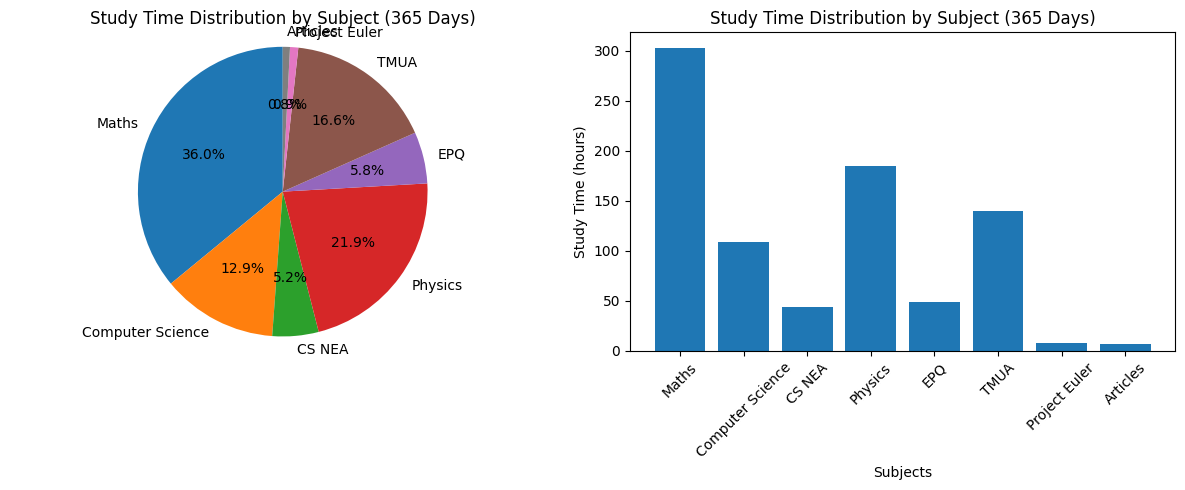

Found 5 events in the past 30 days from Studying.
Found 96 events in the past 30 days from Calendar.
Found 61 events in the past 30 days from Timetable.
Total study time in the past 30 days: 119.3 hours
Maths: 61.1 hrs, Computer Science: 16.2 hrs, CS NEA: 8.5 hrs, Physics: 33.6 hrs, 


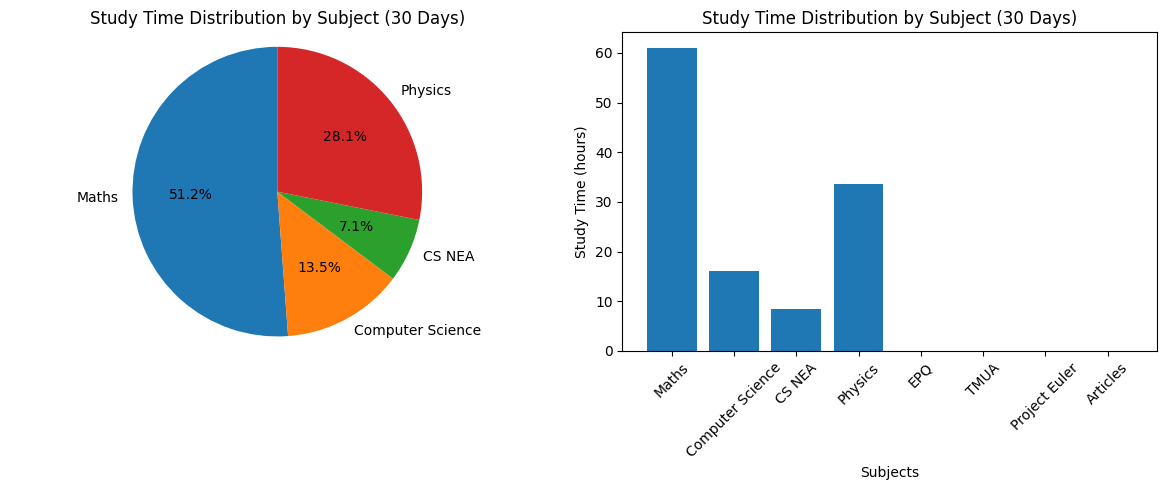

Found 5 events in the past 12 days from Studying.
Found 47 events in the past 12 days from Calendar.
Found 0 events in the past 12 days from Timetable.
Total study time in the past 12 days: 40.2 hours
Maths: 24.9 hrs, Computer Science: 2.5 hrs, Physics: 12.8 hrs, 


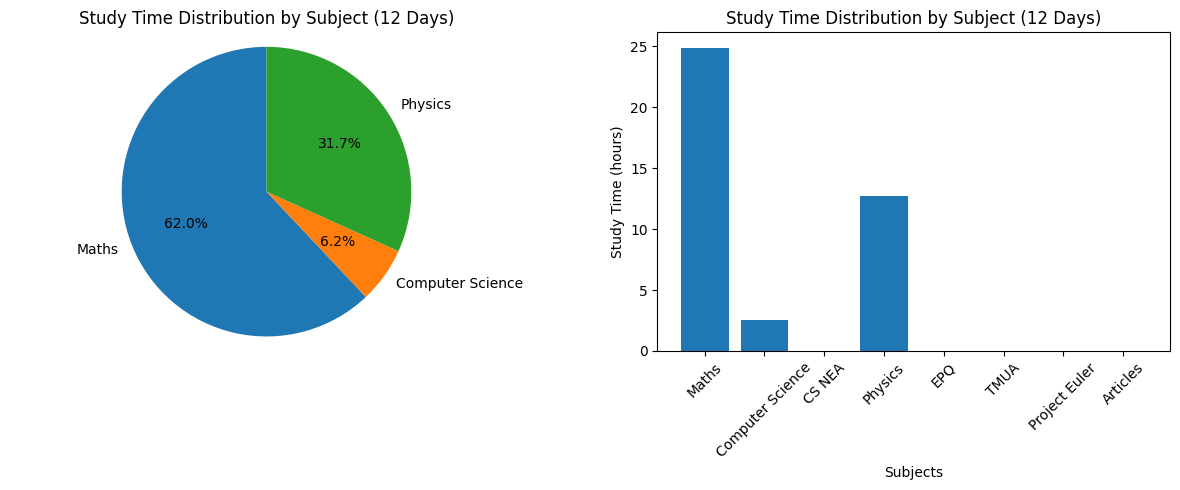

Total planned study time for today (filtered by subjects): 4.5 hours
Total planned study time for today (filtered by subjects): 4.2 hours
No events found for today.
No events found for today.
Total study time completed today: 8.6 hours
Percentage of planned study time completed today: 98%


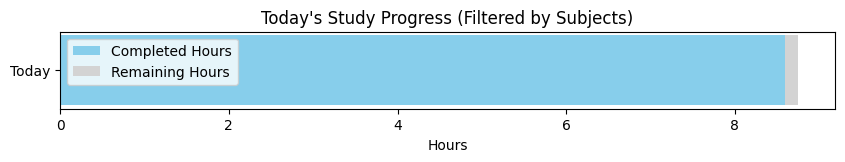

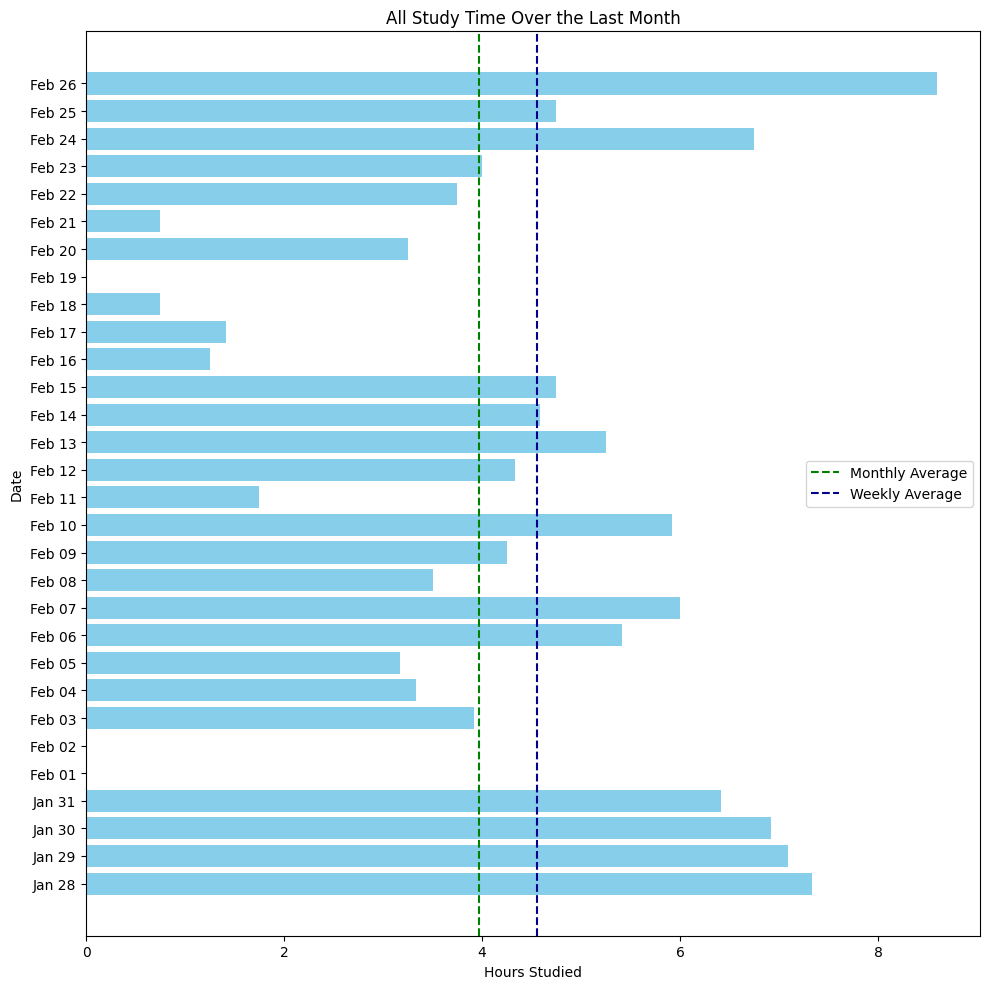

Total hours studied by 24 February 2025: -15 hours
Total hours per subject by 24 February 2025: -5 hours


In [99]:
subjects = {
    "Maths": ["maths", "math", "mathematics"],
    "Computer Science": ["computer science", "comp sci", "compsci"],
    "CS NEA": ["cs nea", "csc"],
    "Physics": ["physics", "phys"],
    "EPQ": ["epq"],
    "TMUA": ["tmua"],
    "Project Euler": ["project euler"],
    "Articles": ["medium", "article", "blog"]
}

service = authenticate_google_calendar()
calendar_ids = [
    "0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com",
    "billjrimell@gmail.com",
    "b7ca60b7b46309b1e408a4a240a5456ca98cb4af51ad62d260ae8ae4fd0ce45d@group.calendar.google.com" # timetable
]

display_all_study_stats(service, calendar_ids)

# Plot today's progress and daily subject study time (using partial progress)
plot_today_study_progress(service, calendar_ids, subjects)
# Uncomment the next line to view overall daily total study time over the past month
# plot_daily_study_time_last_month(service, calendar_ids[0])
plot_daily_subject_study_time_last_month(service, calendar_ids, subject=None, subjects=subjects)

# Example: Calculate average subject study time since a given date
# print(calculate_average_subject_study_time_since(service, calendar_ids[0], "TMUA", subjects, dt.datetime(2024, 5, 25)))

end_date = dt.datetime(2025, 2, 24)
current_date = dt.datetime.now()
days_remaining = (end_date - current_date).days
hours_per_day = 5
total_hours_studied = days_remaining * hours_per_day

print(f"Total hours studied by {end_date.strftime('%d %B %Y')}: {total_hours_studied} hours")
total_hours_per_subject = total_hours_studied / 3
print(f"Total hours per subject by {end_date.strftime('%d %B %Y')}: {total_hours_per_subject:.0f} hours")
